In [1]:
import csv
import pandas as pd
import numpy as np

In [2]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 19:59:22) \n[GCC 7.3.0]'

## Dataset Preparation

1. Take a pickle dataset, and open into Pandas. Note that the given data is un-normalized.
2. Partition the global dataset into training (**80**%) and testing (**20**%) sets.

In [3]:
import pandas as pd

# Load the .pkl file containing the data points
path = 'data/jet_particles.pkl'

# Read the .pkl file with Pandas
dataset = pd.read_pickle(path)

total_len = len(dataset)

# Slice training and testing sets from the total data given
train_set = dataset[0:int(0.8*total_len)]
test_set = dataset[int(0.8*total_len):]

See the format of the un-normalized dataframe heads.

In [4]:
print('Training sample:')
print(train_set.head())

print('Testing sample:')
print(test_set.head())

print('The number of entries in the training data:', len(train_set))
print('The number of entries in the testing data:', len(test_set))
print('----------------------------------------------------------')

Training sample:
          E        pt       eta      phi
0  258722.0  243675.0  0.328962  2.25014
1  520092.0  108590.0 -2.247300 -1.85679
2  383024.0   88405.6  2.145160 -1.95635
3   39507.6   35365.1  0.470460 -1.16445
4  225430.0   26878.2 -2.816080 -2.25938
Testing sample:
               E        pt       eta       phi
18128    31667.3   31188.0 -0.034852 -1.064850
18129  1220580.0  563494.0  1.407610  1.774810
18130   183789.0  144274.0 -0.714607 -1.638620
18131   105035.0   30664.6 -1.900490  0.944864
18132   458817.0  330407.0 -0.840037  0.899706
The number of entries in the training data: 18128
The number of entries in the testing data: 4533
----------------------------------------------------------


### Normalize the Dataset

In [5]:
# Function to normalize the data
def custom_normalize(df):
    df['eta'] = df['eta'] / 5
    df['phi'] = df['phi'] / 3
    df['E'] = np.log(df['E']+1e-8) / 20
    df['pt'] = np.log((df['pt']+ 1e-8)) / 20
    return df

In [6]:
import warnings
warnings.filterwarnings("ignore")

train_set = custom_normalize(train_set)
test_set = custom_normalize(test_set)

See the format of the un-normalized dataframe heads.

In [7]:
print('Training sample:')
print(train_set.head())

print('Testing sample:')
print(test_set.head())

print('The number of entries in the training data:', len(train_set))
print('The number of entries in the testing data:', len(test_set))
print('----------------------------------------------------------')

Training sample:
          E        pt       eta       phi
0  0.623175  0.620180  0.065792  0.750047
1  0.658088  0.579767 -0.449460 -0.618930
2  0.642793  0.569485  0.429032 -0.652117
3  0.529212  0.523674  0.094092 -0.388150
4  0.616288  0.509954 -0.563216 -0.753127
Testing sample:
              E        pt       eta       phi
18128  0.518152  0.517389 -0.006970 -0.354950
18129  0.700742  0.662096  0.281522  0.591603
18130  0.606077  0.593973 -0.142921 -0.546207
18131  0.578102  0.516543 -0.380098  0.314955
18132  0.651820  0.635404 -0.168007  0.299902
The number of entries in the training data: 18128
The number of entries in the testing data: 4533
----------------------------------------------------------


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

In [8]:
import os
in_save_dir = "plotInput"
if not os.path.exists(in_save_dir):
    os.makedirs(in_save_dir)

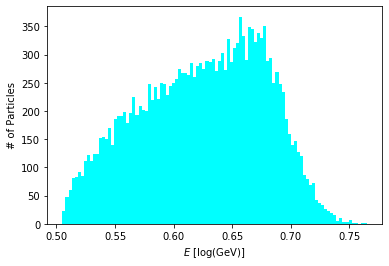

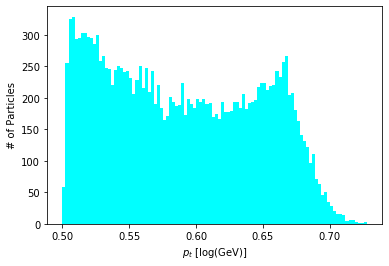

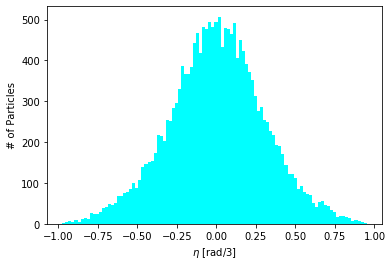

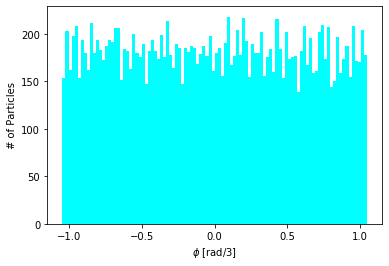

In [9]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/3]', '[rad/3]']
variable_list = [r'$E$', r'$p_t$', r'$\eta$', r'$\phi$']

branches=["E","pt","eta","phi"]

n_bins = 100


for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train_set[branches[kk]], color='cyan', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of Particles')
    plt.savefig(os.path.join(in_save_dir,"fourmomentum_"+branches[kk]),dpi=300)
    plt.show()

## Setting up the AutoEncoder

### Preparing the data

1. Adding the two datasets as TensorDatasets to PyTorch.
2. Import statements.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train_set
test_x = test_set
train_y = train_set  # y = x since we are building an autoencoder
test_y = test_set

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [11]:
bs = 64

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Details aren't too important, as long as they match what was already trained for us. In this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4.

In [12]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4, enc_features=3):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, enc_features)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [13]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

## Alternative 1: Running a pre-trained network

Now we load the pre-trained network (Uncomment the code below)

In [14]:
# learn.load("AE_3D")

Then we evaluate the MSE on this network: it should be of the order of 0.001 or less if all has gone well. If it has not trained well, then it's going to be a bit higher.

In [15]:
# learn.validate()

## Alternative 2: Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.005754399299621582
Learning rate with the steepest gradient: 0.0004786300996784121


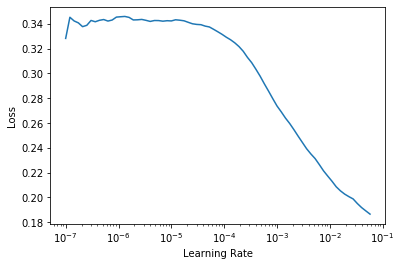

In [16]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [17]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min * 0.1)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

## Uncomment to save a model for later validation
# learn.save('AE_3D')

[0, 0.04330918565392494, 0.02839025855064392, '00:06']
[0, 0.04330918565392494, 0.02839025855064392, '00:06']
[1, 0.016060184687376022, 0.0090187331661582, '00:04']
[1, 0.016060184687376022, 0.0090187331661582, '00:04']
[2, 0.0025066365487873554, 0.002294184872880578, '00:04']
[2, 0.0025066365487873554, 0.002294184872880578, '00:04']
[3, 0.0018867886392399669, 0.0017544759903103113, '00:04']
[3, 0.0018867886392399669, 0.0017544759903103113, '00:04']
[4, 0.001451630494557321, 0.0013176926877349615, '00:04']
[4, 0.001451630494557321, 0.0013176926877349615, '00:04']
[5, 0.0005288398824632168, 0.00036140685551799834, '00:04']
[5, 0.0005288398824632168, 0.00036140685551799834, '00:04']
[6, 0.0002575836842879653, 0.00023557254462502897, '00:06']
[6, 0.0002575836842879653, 0.00023557254462502897, '00:06']
[7, 0.00020012377353850752, 0.00020071280596312135, '00:05']
[7, 0.00020012377353850752, 0.00020071280596312135, '00:05']
[8, 0.00015213893493637443, 0.00014508696040138602, '00:05']
[8, 0.0

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

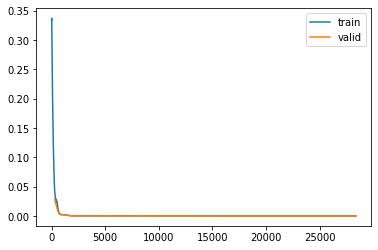

In [20]:
recorder.plot_loss()

Then we evaluate the MSE on this network: it should be of the order of 0.001 or less if all has gone well. If it has not trained well, then it's going to be a bit higher.

In [21]:
learn.validate()

(#1) [5.04673266732425e-07]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

In [22]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities

In [23]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**(df['E'] * 20) - 1e-8 
    df['pt'] = 10**(df['phi'] * 20) - 1e-8
    return df

Make the histograms from the test dataset

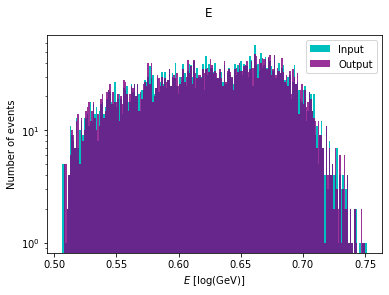

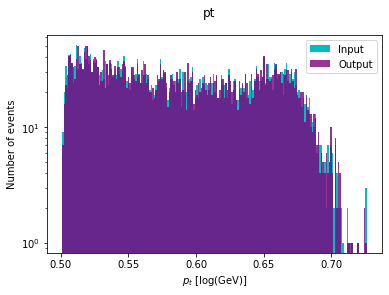

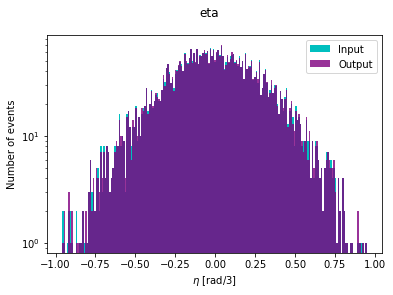

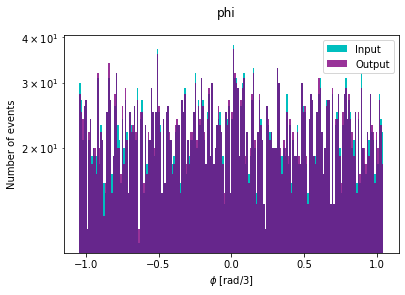

In [25]:
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')
unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/3]', '[rad/3]']
variable_list = [r'$E$', r'$p_t$', r'$\eta$', r'$\phi$']
line_style = ['--', '-']
colors = ['purple', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
# idxs = (0, 4000)  # Choose events to compare
data = torch.tensor(test_set.values, dtype=torch.float)
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test_set.columns)
pred_df = pd.DataFrame(pred, columns=test_set.columns)

## Uncomment and replace the values in the plt.hist() with data_def.values and pred_def.values to plot original values
# data_df = custom_unnormalize(data_df)
# pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test_set.columns[kk])
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    plt.legend()
    if save:
        plt.savefig(os.path.join(save_dir,test_set.columns[kk]+'.png'))

In [26]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
print(rat)

[-0.06666666666666667, -0.07407407407407407, 0.14285714285714285, 0.0, 0.0, 0.0, 0.047619047619047616, 0.0, -0.05263157894736842, 0.0, 0.05263157894736842, -0.10526315789473684, 0.03225806451612903, 0.1111111111111111, -0.043478260869565216, 0.0, -0.1875, 0.06666666666666667, 0.0, 0.0967741935483871, 0.0, -0.11764705882352941, 0.0, 0.07692307692307693, 0.0, -0.13043478260869565, -0.047619047619047616, 0.0625, 0.08333333333333333, -0.1, 0.07407407407407407, -0.045454545454545456, 0.0, 0.0, -0.043478260869565216, 0.045454545454545456, 0.0, 0.047619047619047616, -0.06896551724137931, 0.09090909090909091, 0.041666666666666664, -0.07407407407407407, 0.06666666666666667, 0.0, -0.05555555555555555, 0.047619047619047616, 0.0, 0.0, 0.0, 0.05263157894736842, 0.0, -0.02702702702702703, 0.04, -0.043478260869565216, 0.0, 0.0, 0.0, 0.0, 0.0, 0.047619047619047616, 0.0, -0.05555555555555555, -0.05263157894736842, 0.045454545454545456, 0.043478260869565216, 0.0, -0.0625, 0.0, 0.0, -0.034482758620689655